In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# Read data

## COVID Cases

In [2]:
def read_csv_country(file_path, location):
    df = pd.read_csv(file_path, index_col=0)
    df = df[df.index == location]
    df = df.T
    df.columns.name = None
    if 'weekly' not in file_path:
        df.index = pd.to_datetime(df.index)
    else:
        df.index = pd.to_numeric(df.index)
    df = df.reset_index()
    df = df.rename(columns={'index':'date', location:'Cases'})
    
    return df

In [3]:
def plot_cases(df):
    plt.figure(figsize = (12, 8))
    plt.plot(df.date, df.Cases, color ='blue')
    plt.xlabel('Date') 
    plt.ylabel('Covid Cases')
    plt.show()

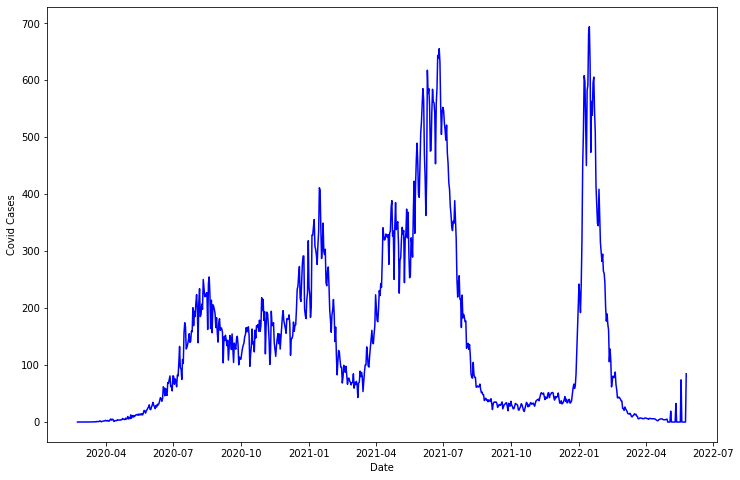

,date,Cases
0,2020-02-23,0.000
1,2020-02-24,0.000
2,2020-02-25,0.000
3,2020-02-26,0.000
4,2020-02-27,0.000
...,...,...
819,2022-05-22,0.000
820,2022-05-23,0.000
821,2022-05-24,0.000
822,2022-05-25,0.000


In [4]:
file_path = 'COVID_LATAM/Output/daily_covid_cases_latam.csv'
location = 'Colombia'

covid_cases = read_csv_country(file_path, location)
plot_cases(covid_cases)
covid_cases

## Media Cloud Data

In [5]:
def read_mediacloud_csv(media_cloud_file_path, location, filter_df=False, option=3):
    # Read file
    df = pd.read_csv(media_cloud_file_path)
    
    # Add column names
    column_names = [column for column in df.columns if location in column]
    column_names.insert(0, 'date')
    if not filter_df:
        print(f'The selected columns are : {column_names}')
    
    # Filter based on location
    df = df[column_names]
    
    name = ''
    if filter_df:
        if option == 0:
            var = 'count'
            name = 'Count'
        elif option == 1:
            var = 'total_count'
            name = 'Total Count'
        else:
            name = 'Ratio'
            var = 'ratio'
        
        var = var + '_' + location
        column_names = [column for column in df.columns if var == column]  
        column_names.insert(0, 'date')
        print(f'The selected columns are : {column_names}')
        df = df[column_names]

    df.date = pd.to_datetime(df.date)
    plot_media_cloud(df, name)
    return df

In [6]:
def plot_media_cloud(df, name):
    plt.figure(figsize = (12, 8))
    
    columns = df.columns
    
    if len(columns) > 2:
        plt.plot(df.date, df[columns[1]], color ='blue', label='Count')
        plt.plot(df.date, df[columns[2]], color ='black', label='Total Count')
        plt.plot(df.date, df[columns[3]], color ='red', label='Ratio')
    else:
        plt.plot(df.date, df[columns[1]], color ='blue', label=name)
        
    plt.xlabel('Date') 
    plt.ylabel('Meida Cloud Score')
    plt.legend()
    plt.show()
    

The selected columns are : ['date', 'ratio_Colombia']


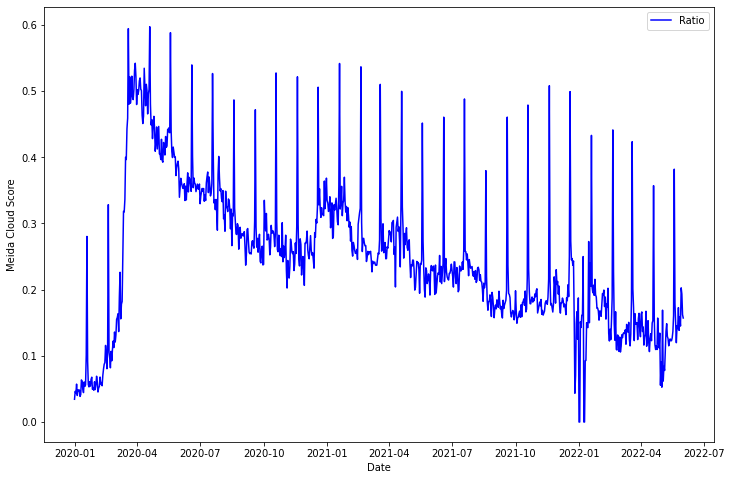

,date,ratio_Colombia
0,2020-01-01,0.034388
1,2020-01-02,0.046326
2,2020-01-03,0.043379
3,2020-01-04,0.057274
4,2020-01-05,0.040115
...,...,...
878,2022-05-28,0.145021
879,2022-05-29,0.202751
880,2022-05-30,0.193417
881,2022-05-31,0.162197


In [7]:
#media_cloud_file_path = 'Media_Cloud_Data/Attention_COVID_Vaccination_National/covid_vaccination_attention_latam.csv'
media_cloud_file_path = 'Media_Cloud_Data/Attention _COVID-19_National/covid-19_attention_latam.csv'

mediaCloud = read_mediacloud_csv(media_cloud_file_path, location, filter_df=True, option=3)
mediaCloud

## Merge Dataframes

In [8]:
covid_df = mediaCloud.merge(covid_cases, how='inner', on="date")
covid_df.set_index('date', inplace=True)
covid_df

,ratio_Colombia,Cases
date,,
2020-02-23,0.106789,0.000
2020-02-24,0.092520,0.000
2020-02-25,0.110045,0.000
2020-02-26,0.122388,0.000
2020-02-27,0.112483,0.000
...,...,...
2022-05-22,0.119860,0.000
2022-05-23,0.145599,0.000
2022-05-24,0.141133,0.000


# Pre-processing

## Prepare data to supervised learning time series

we will use:

* data: is the dataframe in our case (Covid Cases and Google Mobile Data)
* n_in: is the number of lag weeks in the past (length of window)

The heart of this "series_to_supervised" function is the <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html">shift</a> fuction of pandas

This function gets as input the number of periods(in this case the number of days represented as rows up or down in the dataframe) to move the columns of a dataframe. E.g.

If we have df.shift(1) all the rows of column cases_medellin will move one row down
If we have df.shift(-1) all the rows of column cases_medellin will move one row up

In [9]:
# prepare data for lstm

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


## normalize features
As we are working with a Neural Network the data values ​​must be normalized to help backpropagation algorithm So we will use the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html">MinMaxScaler</a> from sklearn

In [10]:
def normalize_features(df, normalize_y=True, feature_range=(0, 1)):
    # Take features and labels
    x = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    
    # add one dimension to y to be (n_instances, 1)
    y = np.expand_dims(y.to_numpy(),axis=1)
    
    # Normalize x
    scaler_x = MinMaxScaler(feature_range=feature_range) # Scaler between feature_range. By default 0 and 1
    scaled_x = scaler_x.fit_transform(x)
    
    # Normalize y
    if normalize_y:
        scaler_y = MinMaxScaler(feature_range=feature_range) # Scaler between feature_range. By default 0 and 1
        scaled_y = scaler_y.fit_transform(y)
        scaled = np.concatenate([scaled_x, scaled_y], axis=1)
        return scaled, scaler_y
    else:
        scaled = np.concatenate([scaled_x, y], axis=1)
        return scaled

In [11]:
normalize_y = True
feature_range = (-1, 1)

#scaled = normalize_features(df=covid_df, normalize_y=normalize_y, feature_range=feature_range)
scaled, scaler_y = normalize_features(df=covid_df, normalize_y=normalize_y, feature_range=feature_range)

# length of window
days = 7

# frame as supervised learning
data = series_to_supervised(scaled, n_in=days)
DataFrame(data)

,var1(t-7),var2(t-7),var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
7,-0.642447,-1.000000,-0.690224,-1.000000,-0.631544,-1.000000,-0.590219,-1.000000,-0.623381,-1.000000,-0.544727,-1.0,-0.595424,-1.0,-0.559750,-1.000000
8,-0.690224,-1.000000,-0.631544,-1.000000,-0.590219,-1.000000,-0.623381,-1.000000,-0.544727,-1.000000,-0.595424,-1.0,-0.559750,-1.0,-0.480629,-1.000000
9,-0.631544,-1.000000,-0.590219,-1.000000,-0.623381,-1.000000,-0.544727,-1.000000,-0.595424,-1.000000,-0.559750,-1.0,-0.480629,-1.0,-0.471170,-1.000000
10,-0.590219,-1.000000,-0.623381,-1.000000,-0.544727,-1.000000,-0.595424,-1.000000,-0.559750,-1.000000,-0.480629,-1.0,-0.471170,-1.0,-0.452454,-1.000000
11,-0.623381,-1.000000,-0.544727,-1.000000,-0.595424,-1.000000,-0.559750,-1.000000,-0.480629,-1.000000,-0.471170,-1.0,-0.452454,-1.0,-0.542511,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,-0.588588,-1.000000,-0.574324,-1.000000,-0.542336,-1.000000,-0.462359,-1.000000,0.279111,-0.786648,-0.400056,-1.0,-0.498430,-1.0,-0.598683,-1.000000
820,-0.574324,-1.000000,-0.542336,-1.000000,-0.462359,-1.000000,0.279111,-0.786648,-0.400056,-1.000000,-0.498430,-1.0,-0.598683,-1.0,-0.512504,-1.000000
821,-0.542336,-1.000000,-0.462359,-1.000000,0.279111,-0.786648,-0.400056,-1.000000,-0.498430,-1.000000,-0.598683,-1.0,-0.512504,-1.0,-0.527456,-1.000000
822,-0.462359,-1.000000,0.279111,-0.786648,-0.400056,-1.000000,-0.498430,-1.000000,-0.598683,-1.000000,-0.512504,-1.0,-0.527456,-1.0,-0.421308,-1.000000


### Features Set

In [12]:
# We define the number of features as (Cases and media cloud)
n_features = scaled.shape[1]

# The features to train the model will be all except the values of the actual week 
# We can't use the temperature and precipitation in week t because whe need to resample a a 3D Array
features_set = DataFrame(data.values[:,:-n_features])
# Convert pandas data frame to np.array to reshape as 3D Array
features_set = features_set.to_numpy()
features_set.shape

(817, 14)

### Labels Set

In [13]:
# We will use Dengue cases in last week 
labels_set = DataFrame(data.values[:,-1])
# Convert pandas data frame to np.array
labels_set = labels_set.to_numpy()
labels_set.shape

(817, 1)

## Train Test Split

In [14]:
# We need a sequence so we can't split randomly
# To divide into Train (90%) and test (10%) to do that we need to know the 90% of the total dataframe
size = features_set.shape[0]
split = int(size*(9/10))

### Train

In [15]:
# We will train with 1st 90% of data and test with last 10%
train_X = features_set[:split] ##90% train
train_y = labels_set[:split]  ##90% train

### Test

In [16]:
test_X = features_set[split:] ##10% test
test_y = labels_set[split:] ##10% test

### Reshape to tensor

In [17]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], days, n_features))
test_X = test_X.reshape((test_X.shape[0], days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(735, 7, 2) (735, 1) (82, 7, 2) (82, 1)


# Model
## LSTM

In [18]:
# Set Seed
tf.random.set_seed(0)

# design network
model = Sequential()
model.add(LSTM(120, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(240, input_shape=(train_X.shape[1], 120)))
model.add(Dense(60))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

Metal device set to: Apple M1


2022-07-10 12:08:14.895186: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-10 12:08:14.895301: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 120)            59040     
                                                                 
 lstm_1 (LSTM)               (None, 240)               346560    
                                                                 
 dense (Dense)               (None, 60)                14460     
                                                                 
 dense_1 (Dense)             (None, 1)                 61        
                                                                 
Total params: 420,121
Trainable params: 420,121
Non-trainable params: 0
_________________________________________________________________


## Train

In [20]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50


2022-07-10 12:08:15.365973: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-10 12:08:16.459632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-10 12:08:16.661945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-10 12:08:16.736849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-10 12:08:16.838237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-10 12:08:16.943424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 - 2s - loss: 0.3122 - val_loss: 0.3943 - 2s/epoch - 205ms/step
Epoch 2/50


2022-07-10 12:08:17.460905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-10 12:08:17.530983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-10 12:08:17.558311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 - 0s - loss: 0.1217 - val_loss: 0.0832 - 196ms/epoch - 18ms/step
Epoch 3/50
11/11 - 0s - loss: 0.2575 - val_loss: 0.3174 - 156ms/epoch - 14ms/step
Epoch 4/50
11/11 - 0s - loss: 0.1759 - val_loss: 0.0635 - 146ms/epoch - 13ms/step
Epoch 5/50
11/11 - 0s - loss: 0.0997 - val_loss: 0.1122 - 149ms/epoch - 14ms/step
Epoch 6/50
11/11 - 0s - loss: 0.1647 - val_loss: 0.0651 - 149ms/epoch - 14ms/step
Epoch 7/50
11/11 - 0s - loss: 0.1602 - val_loss: 0.0785 - 163ms/epoch - 15ms/step
Epoch 8/50
11/11 - 0s - loss: 0.1281 - val_loss: 0.0776 - 153ms/epoch - 14ms/step
Epoch 9/50
11/11 - 0s - loss: 0.1395 - val_loss: 0.1346 - 158ms/epoch - 14ms/step
Epoch 10/50
11/11 - 0s - loss: 0.1371 - val_loss: 0.0484 - 157ms/epoch - 14ms/step
Epoch 11/50
11/11 - 0s - loss: 0.0845 - val_loss: 0.0586 - 156ms/epoch - 14ms/step
Epoch 12/50
11/11 - 0s - loss: 0.1218 - val_loss: 0.0646 - 151ms/epoch - 14ms/step
Epoch 13/50
11/11 - 0s - loss: 0.1585 - val_loss: 0.0317 - 156ms/epoch - 14ms/step
Epoch 14/50
11/11 - 0s 

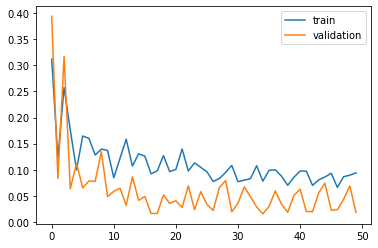

In [21]:
from matplotlib import pyplot
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

# Test

In [22]:
from math import sqrt
from numpy import concatenate

def test_model(model, test_X, test_y, normalize_y):
    
    # do the prediction
    yhat = model.predict(test_X)
    
    # Invert scaling for forecast
    # Inverse Scaler
    if normalize_y:       
        #test_y = test_y.reshape((len(test_y), 1))
        inv_yhat = scaler_y.inverse_transform(yhat)
        inv_y = scaler_y.inverse_transform(test_y)
    else:
        inv_yhat = yhat 
        inv_y = test_y
    
    return inv_yhat, inv_y

In [23]:
inv_yhat, inv_y = test_model(model=model, test_X=test_X, test_y=test_y, normalize_y=normalize_y)

2022-07-10 12:08:25.655403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-10 12:08:25.719660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-10 12:08:25.750361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Error function

In [24]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [25]:
# calculate MAPE
mape = mean_absolute_percentage_error(inv_y, inv_yhat)
print('Test MAPE: %.3f' % mape)

Test MAPE: inf


/var/folders/4w/k6c16td51cv9ytcmnnvx3mpw0000gn/T/ipykernel_32890/4111968303.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [26]:
from sklearn.metrics import  mean_absolute_error

# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 6.310


# Plot predicted vs actual dengue cases

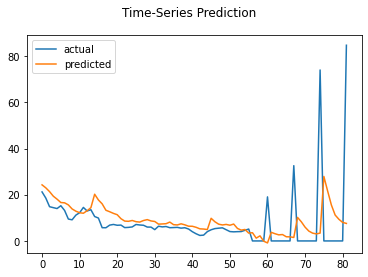

In [27]:
data_predict = inv_yhat  ## predicted target  cases
dataY_plot = inv_y  ##  real test-target cases

data_predict = data_predict.reshape(len(data_predict), 1)
dataY_plot = dataY_plot.reshape(len(dataY_plot), 1)

plt.plot(dataY_plot, label = 'actual')
plt.plot(data_predict, label = 'predicted')
plt.legend(loc="upper left")

plt.suptitle('Time-Series Prediction')
plt.show()